# Using a K-nearest Neighbours Classifier To Detect Bank Account Opening Fraud
### 2022W2 DSCI 100 Group Project

Team Members:
- Aqil Faizal
- Andrei Chepakovich
- Jiaying Ong
- Lucy Liu

## Introduction
Fraud is a major problem in Canada, with a total of $531M being lost to fraud in 2022 according to the Canadian Anti-Fraud Centre. Although overall rates of digital financial fraud in Canada have fallen in recent years, identity theft rates have been on the rise. According to Statista, an online platform for consumer data, the rate of identity fraud in Canada has consistently grown from 2008 to 2021 and sat at 61.95 per 100,000 residents in the latter year. Identity thieves commonly use stolen personal information to create new bank accounts with which they will then perform fraudulent activities such as credit card fraud, fraudulent loan applications, and money laundering. This act is known as account opening fraud, and will be the focus of this group project.

In this project, we aim to use the R tidymodels framework to build a K-nearest neighbours classifier that can classify a bank account as fraudulent or non-fraudulent using data from the Bank Account Fraud suite of datasets published at NeurIPS 2022, a machine learning conference. This synthetic dataset is based on real-world bank account data. The main questions that we would like to answer in this project are: 1) given this data, can we use the K-nearest neighbours algorithm to classify a bank account as fraudulent or non-fraudulent with reasonable accuracy, and 2) which variables are good indicators of account opening fraud?

### Description of the dataset
We will use the Base.csv dataset from the aforementioned Bank Account Fraud suite, which has 32 variables and 1M observations. As the K-nearest neighbours algorithm will be very computationally costly with such a large number of observations, we will first extract the first 100,000 rows of data and then filter it further to obtain only observations with certain attributes.

We also plan to use the forward selection algorithm to select the predictor variables to be used by the KNN model. Since using many variables for forward selection involves the training of many models and increases the chance that we come across a model with a high cross-validation accuracy estimate, but a low true accuracy on the test data, we first examined 6 variables that we felt were most likely to be indicators of fraudulence.

## Preliminary exploratory data analysis

The required libraries for running the code in this proposal are:

- tidyverse
- tidymodels

In [11]:
### Setup
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.3     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.4     ✔ yardstick    1.1.0
✔ recipes      1.0.5     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Dig deeper into tidy modeling with R at https://www.tmwr.org



Since the dataset has 1M rows, we first downloaded Base.csv locally and randomly sampled 100,000 rows, which we then wrote to a .csv file and hosted on Google Sheets. We then read the data in again from Google Sheets:

In [45]:
fraud_data <- read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vRL6hq0R8gYhL5VhHlCOGGSKTea3N54QsEC8zcr5pHwuY2Ly5Zc6G83araSMkzwQF7suK_o6tr-4MEP/pub?output=csv")|>
mutate(fraud_bool=as_factor(fraud_bool))

fraud_data

Rows: 100000 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): payment_type, employment_status, housing_status, source, device_os
dbl (27): fraud_bool, income, name_email_similarity, prev_address_months_cou...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,⋯,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.9,0.16682773,-1,88,50,0.020925173,-1.3313450,AA,769,⋯,0,500,0,INTERNET,3.888115,windows,0,1,0,7
1,0.9,0.29628601,-1,144,50,0.005417538,-0.8162238,AB,366,⋯,0,1500,0,INTERNET,31.798819,windows,0,1,0,7
1,0.9,0.04498549,-1,132,40,3.108548793,-0.7557277,AC,870,⋯,0,200,0,INTERNET,4.728705,other,0,1,0,7
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,0.6,0.8435506,-1,18,40,0.01090603,-0.8543749,AB,602,⋯,0,1500,0,INTERNET,5.939641,other,1,1,0,3
0,0.4,0.6882371,-1,50,20,0.02786849,50.3059704,AA,691,⋯,0,500,0,INTERNET,3.273092,linux,1,1,0,3
0,0.7,0.7537215,-1,50,30,0.02482313,98.5380625,AA,878,⋯,1,500,0,INTERNET,6.452148,windows,0,1,0,3


We then narrowed the dataset down to the 6 variables which we felt were most likely to be indicators of fraudulence, as well as the label to be predicted, which was whether the bank account was fraudulent: 

- Credit risk score
- Income
- Months lived at current address
- Name-email similarity
- Session length in minutes
- Proposed credit limit

In addition, we also filtered for observations from the month of July, with the employment status of 'CA', and the housing status of 'BA'. Since the dataset is synthetic, the employment and housing statuses have arbitrary meaning. We also split the data into training and testing datasets.



In [147]:
set.seed(9999)

fraud_narrowed <- fraud_data |>
    filter(month == 7, employment_status == "CA", housing_status == "BA") |>
    select(fraud_bool, credit_risk_score, income, current_address_months_count, name_email_similarity, session_length_in_minutes, proposed_credit_limit)    
fraud_narrowed

fraud_split <- initial_split(fraud_narrowed, prop = 0.75, strata = fraud_bool)
fraud_train <- training(fraud_split)
fraud_test <- testing(fraud_split) 

fraud_train
fraud_test 

number_of_rows <- nrow(fraud_train)
number_of_rows

fraud_bool,credit_risk_score,income,current_address_months_count,name_email_similarity,session_length_in_minutes,proposed_credit_limit
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,185,0.9,88,0.1668277,3.888115,500
1,259,0.9,144,0.2962860,31.798819,1500
1,110,0.9,22,0.1595112,2.047904,200
⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,179,0.9,134,0.6891395,2.310369,500
0,234,0.9,3,0.5094120,2.943703,1000
0,244,0.8,131,0.8623505,4.555719,1500


fraud_bool,credit_risk_score,income,current_address_months_count,name_email_similarity,session_length_in_minutes,proposed_credit_limit
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,185,0.9,88,0.1668277,3.888115,500
1,259,0.9,144,0.2962860,31.798819,1500
1,295,0.9,218,0.5964137,3.775225,1500
⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,154,0.9,40,0.04758588,1.075560,200
0,266,0.4,141,0.02963662,5.247373,1000
0,244,0.8,131,0.86235045,4.555719,1500


fraud_bool,credit_risk_score,income,current_address_months_count,name_email_similarity,session_length_in_minutes,proposed_credit_limit
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,110,0.9,22,0.1595112,2.047904,200
1,220,0.9,162,0.6115532,3.531939,200
1,143,0.9,186,0.1254526,3.070971,200
⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,46,0.8,137,0.02774166,2.463003,200
0,179,0.9,134,0.68913946,2.310369,500
0,234,0.9,3,0.50941196,2.943703,1000


[1] 11526

We were left with 11526 rows of training data left from our original dataset. The original dataset was already tidy, so there was no need to wrangle it. We then performed more preliminary exploration:

fraud_bool,count
<fct>,<int>
0,10922
1,604


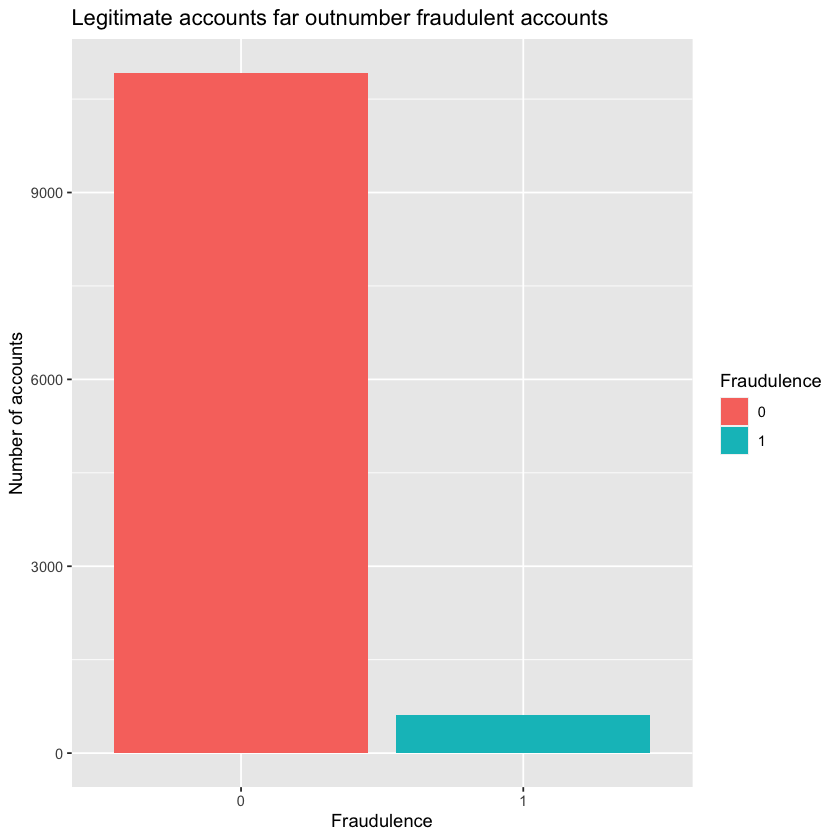

In [186]:
fraud_ratio <- fraud_train |>
    group_by(fraud_bool) |>
    summarize(count = n()) 
    
fraud_ratio_plot <- fraud_ratio |>
    ggplot(aes(x = fraud_bool, y = count, fill = fraud_bool)) +
    geom_bar(stat = "identity") +
    xlab("Fraudulence") +
    ylab("Number of accounts") +
    labs(fill = "Fraudulence") + 
    ggtitle("Legitimate accounts far outnumber fraudulent accounts")

fraud_ratio
fraud_ratio_plot

fraud_bool,credit
<fct>,<dbl>
0,180.2160
1,206.5281


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


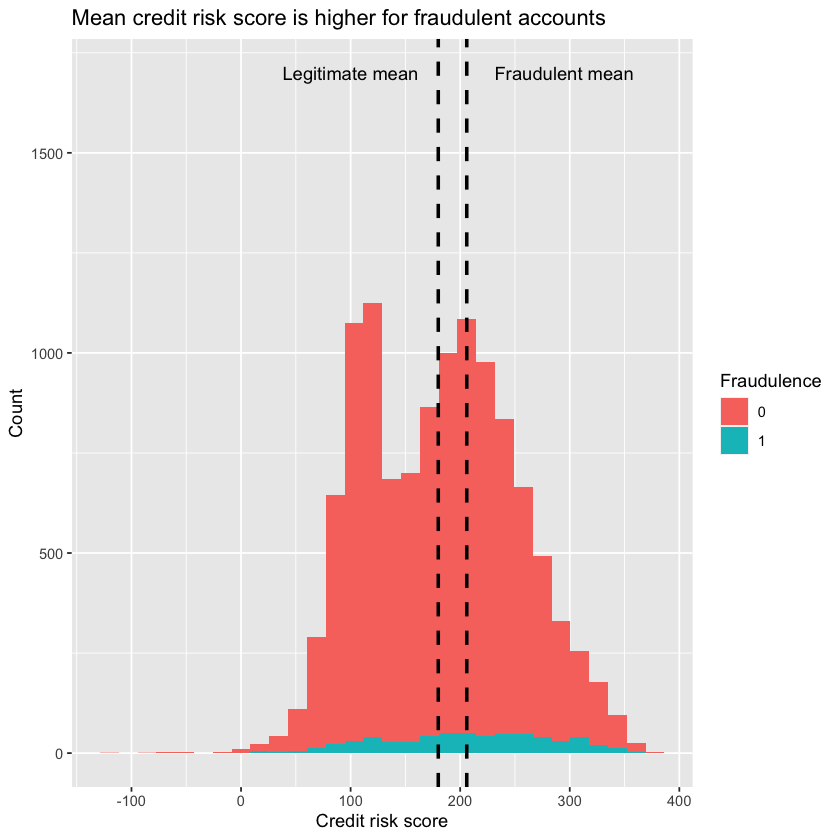

In [151]:
average_credit_risk_score <- fraud_train |>
    group_by(fraud_bool) |>
    summarize(credit = mean(credit_risk_score))

average_credit_risk_score

credit_risk_score_plot <- ggplot(fraud_train, aes(x = credit_risk_score, fill = fraud_bool)) +
  geom_histogram() +
  labs(fill = "Fraudulence") +
  xlab("Credit risk score") +
  ylab("Count") +
  geom_vline(xintercept = 180, linetype = "dashed", size = 1) +
  geom_vline(xintercept = 206, linetype = "dashed", size = 1) +
  annotate("text", x = 100, y = 1700, label = "Legitimate mean") +
  annotate("text", x = 295, y = 1700, label = "Fraudulent mean") +
  ggtitle("Mean credit risk score is higher for fraudulent accounts")

credit_risk_score_plot

fraud_bool,income
<fct>,<dbl>
0,0.6914942
1,0.7382450


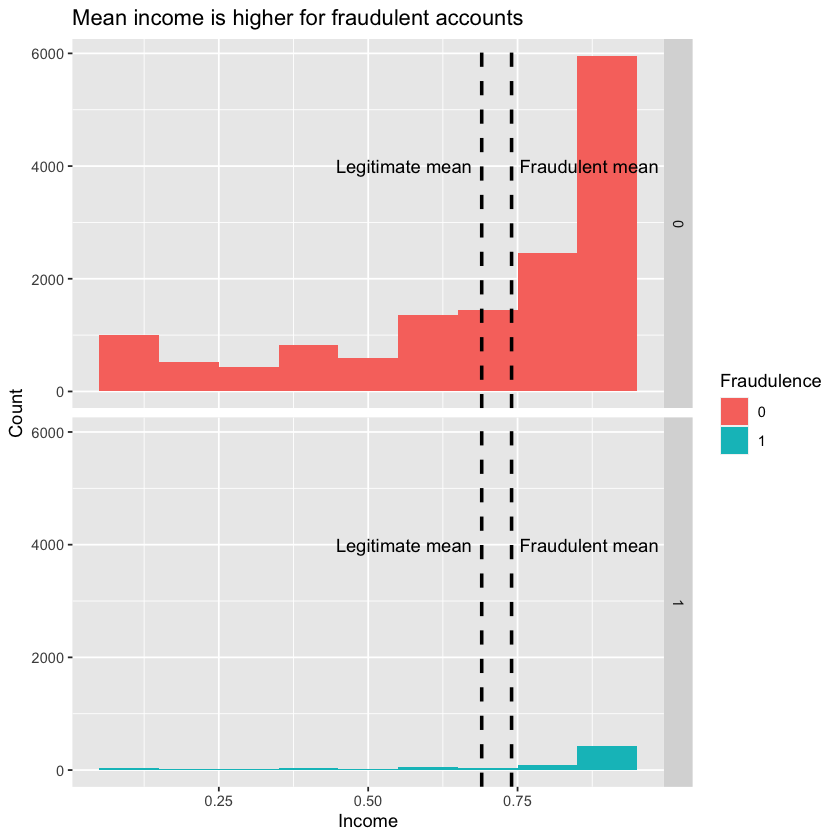

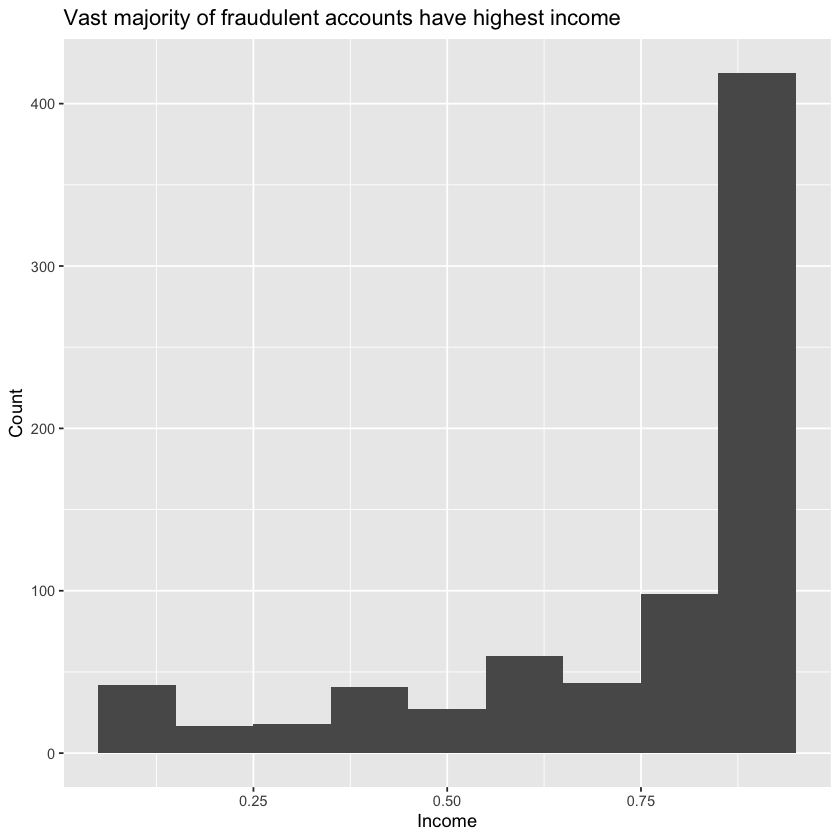

In [152]:
average_income <- fraud_train |>
    group_by(fraud_bool) |>
    summarize(income = mean(income))

average_income

income_plot <- ggplot(fraud_narrowed, aes(x = income, fill = fraud_bool)) +
  geom_histogram(binwidth = 0.1) +
  labs(fill = "Fraudulence") +
  xlab("Income") +
  ylab("Count") +
  geom_vline(xintercept = 0.69, linetype = "dashed", size = 1) +
  geom_vline(xintercept = 0.74, linetype = "dashed", size = 1) +
  annotate("text", x = 0.56, y = 4000, label = "Legitimate mean") +
  annotate("text", x = 0.87, y = 4000, label = "Fraudulent mean") +
  facet_grid(rows = vars(fraud_bool)) +
  ggtitle("Mean income is higher for fraudulent accounts")

fraud_income_plot <- fraud_narrowed |>
  filter(fraud_bool == 1) |>
  ggplot(aes(x = income)) +
  geom_histogram(binwidth = 0.1) +
  xlab("Income") +
  ylab("Count") + 
  ggtitle("Vast majority of fraudulent accounts have highest income")
  

income_plot
fraud_income_plot

fraud_bool,address
<fct>,<dbl>
0,108.8403
1,111.2798


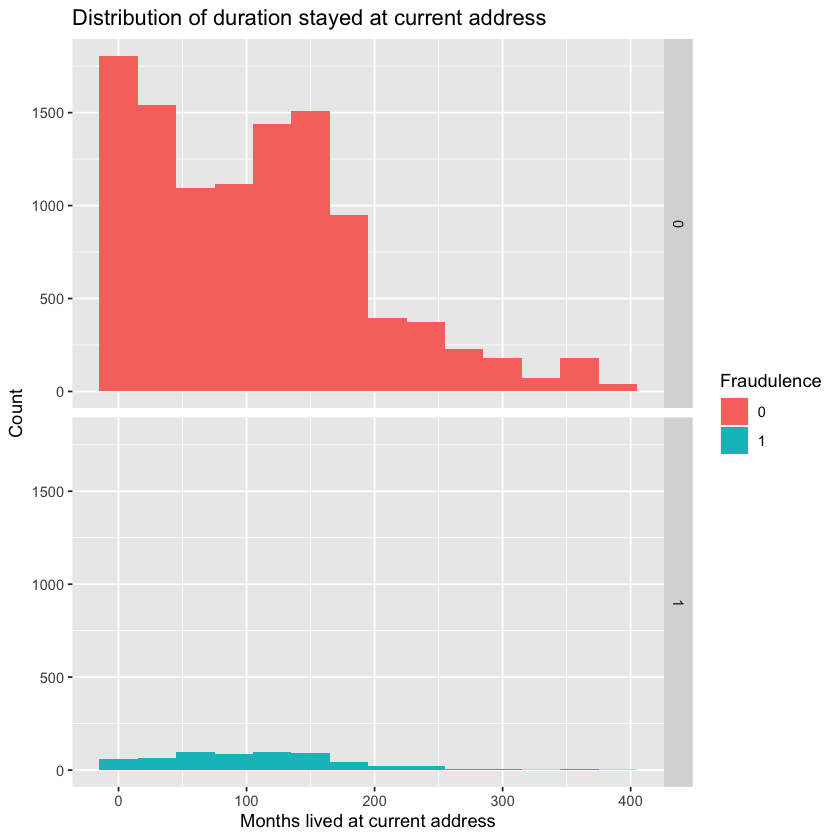

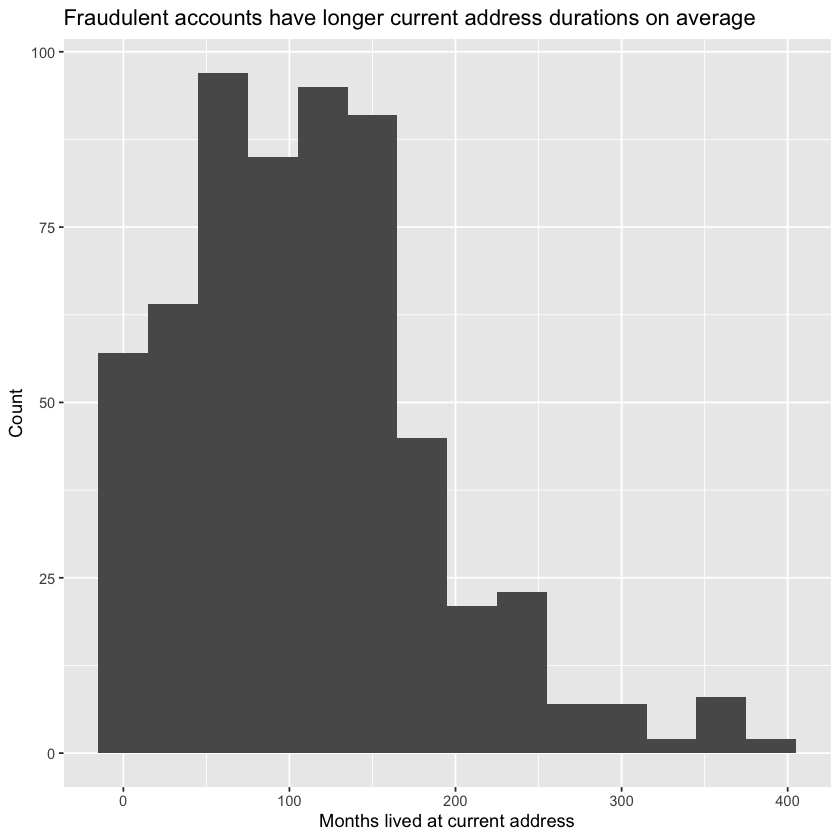

In [169]:
average_address_duration <- fraud_train |>
    group_by(fraud_bool) |>
    summarize(address = mean(current_address_months_count))

average_address_duration

address_duration_plot <- ggplot(fraud_train, aes(x = current_address_months_count, fill = fraud_bool)) +
  geom_histogram(binwidth = 30) +
  labs(fill = "Fraudulence") +
  xlab("Months lived at current address") +
  ylab("Count") +
  facet_grid(rows = vars(fraud_bool)) +
  ggtitle("Distribution of duration stayed at current address")

fraud_address_duration <- fraud_train |>
  filter(fraud_bool == 1) |>
  ggplot(aes(x = current_address_months_count)) +
  geom_histogram(binwidth = 30) +
  xlab("Months lived at current address") +
  ylab("Count") +
  ggtitle("Fraudulent accounts have longer current address durations on average")

address_duration_plot
fraud_address_duration

fraud_bool,similarity
<fct>,<dbl>
0,0.4965410
1,0.3989186


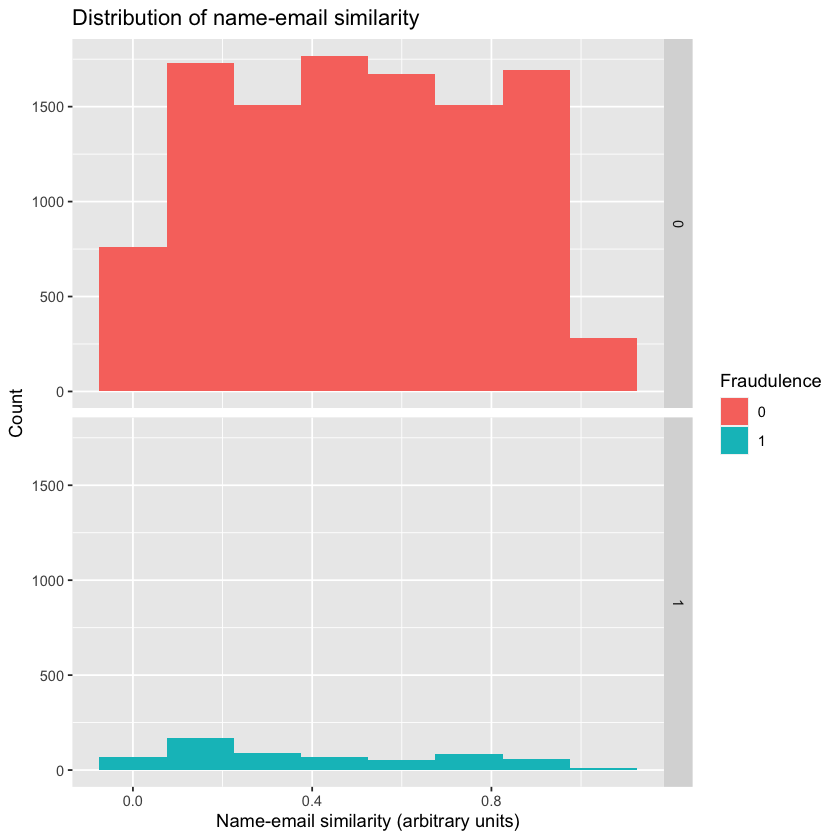

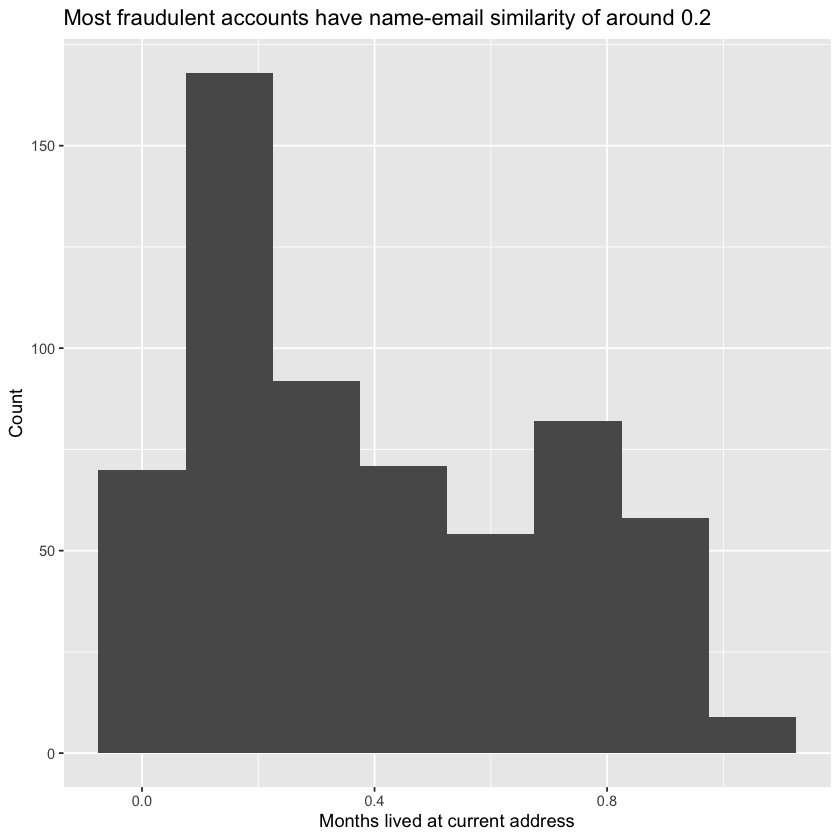

In [161]:
average_similarity <- fraud_train |>
    group_by(fraud_bool) |>
    summarize(similarity = mean(name_email_similarity))

average_similarity 

similarity_plot <- ggplot(fraud_train, aes(x = name_email_similarity, fill = fraud_bool)) +
  geom_histogram(binwidth = 0.15) +
  labs(fill = "Fraudulence") +
  xlab("Name-email similarity (arbitrary units)") +
  ylab("Count") +
  facet_grid(rows = vars(fraud_bool)) +
  ggtitle("Distribution of name-email similarity")

fraud_similarity_duration <- fraud_train |>
  filter(fraud_bool == 1) |>
  ggplot(aes(x = name_email_similarity)) +
  geom_histogram(binwidth = 0.15) +
  xlab("Months lived at current address") +
  ylab("Count") +
  ggtitle("Most fraudulent accounts have name-email similarity of around 0.2")

similarity_plot
fraud_similarity_duration

fraud_bool,similarity
<fct>,<dbl>
0,5.886810
1,7.125959


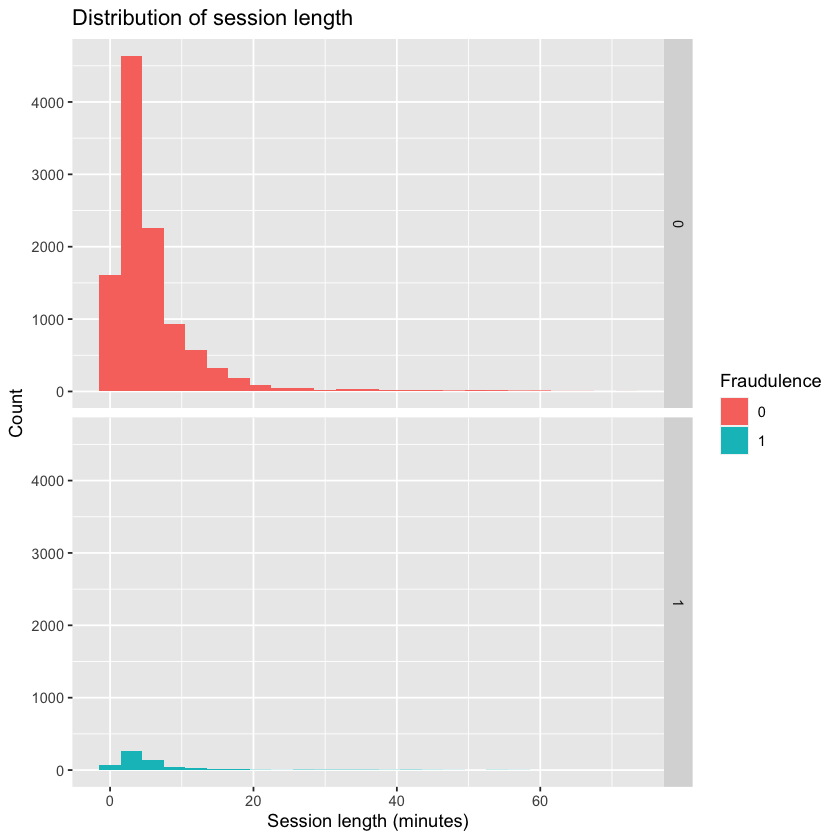

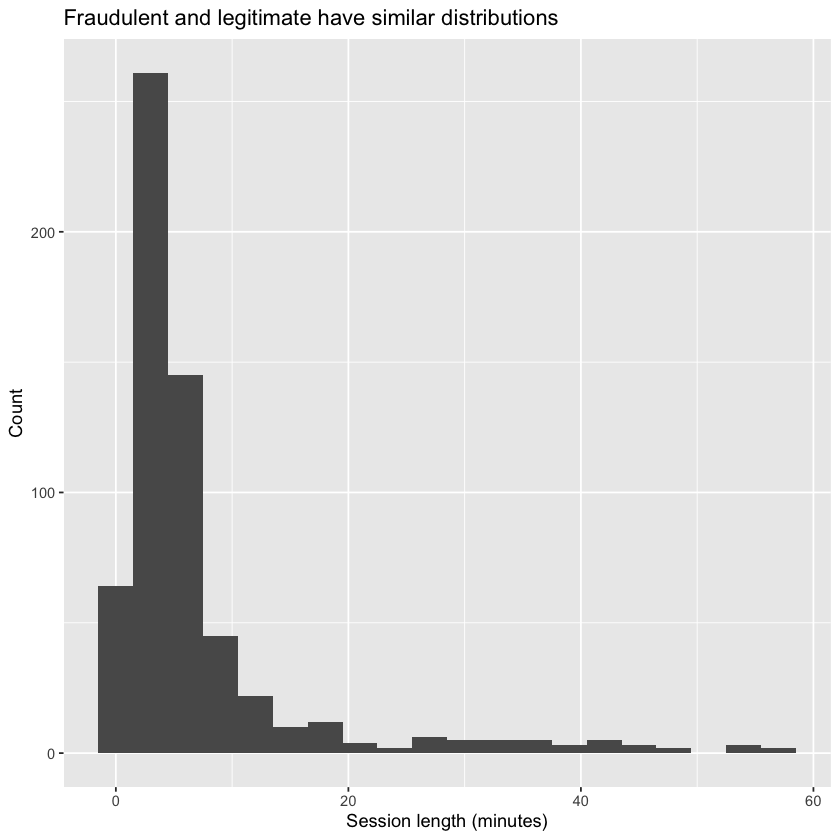

In [168]:
average_session <- fraud_train |>
    group_by(fraud_bool) |>
    summarize(similarity = mean(session_length_in_minutes))

average_session

session_plot <- ggplot(fraud_train, aes(x = session_length_in_minutes, fill = fraud_bool)) +
  geom_histogram(binwidth = 3) +
  labs(fill = "Fraudulence") +
  xlab("Session length (minutes)") +
  ylab("Count") +
  facet_grid(rows = vars(fraud_bool)) +
  ggtitle("Distribution of session length")

fraud_session_duration <- fraud_train |>
  filter(fraud_bool == 1) |>
  ggplot(aes(x = session_length_in_minutes)) +
  geom_histogram(binwidth = 3) +
  xlab("Session length (minutes)") +
  ylab("Count") +
  ggtitle("Fraudulent and legitimate have similar distributions")

session_plot
fraud_session_duration

fraud_bool,similarity
<fct>,<dbl>
0,5.886810
1,7.125959


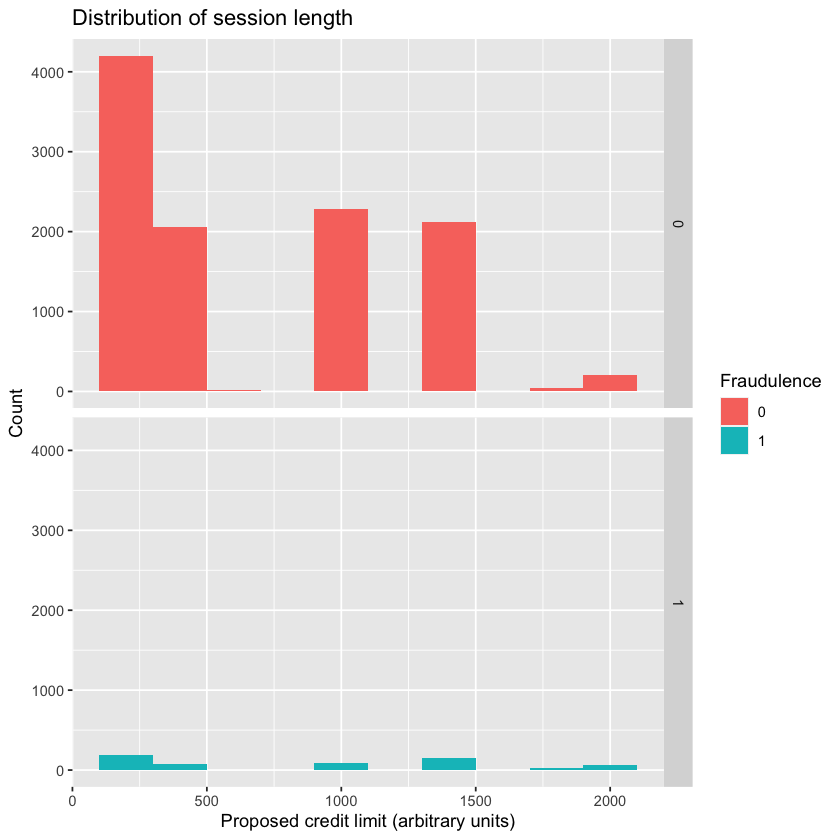

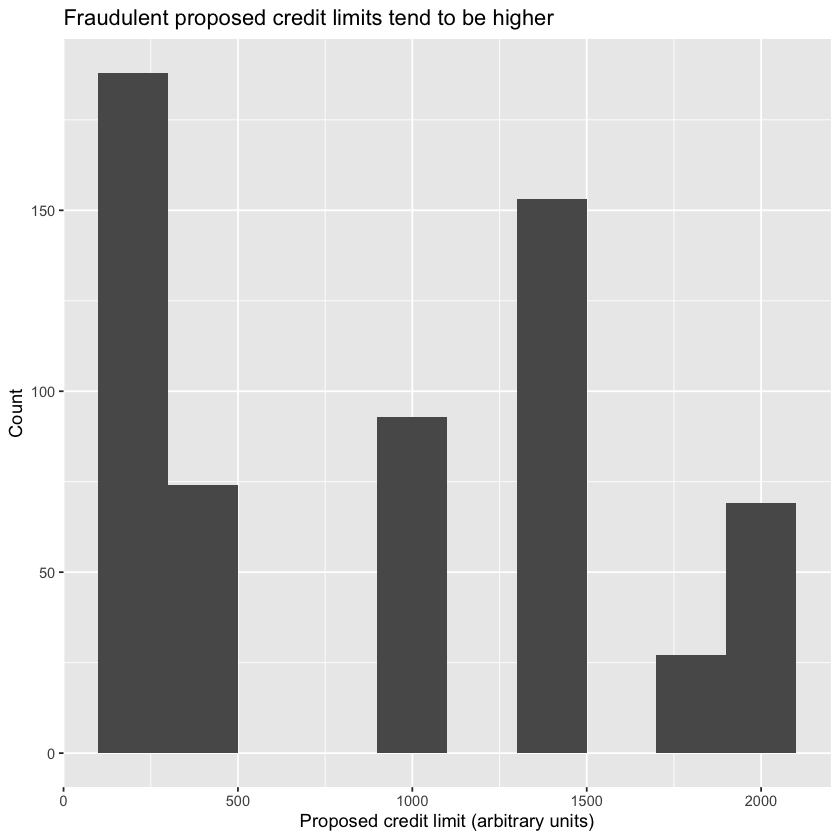

In [174]:
average_proposed_credit_limit <- fraud_train |>
    group_by(fraud_bool) |>
    summarize(similarity = mean(proposed_credit_limit))

average_session

proposed_credit_limit_plot <- ggplot(fraud_train, aes(x = proposed_credit_limit, fill = fraud_bool)) +
  geom_histogram(binwidth = 200) +
  labs(fill = "Fraudulence") +
  xlab("Proposed credit limit (arbitrary units)") +
  ylab("Count") +
  facet_grid(rows = vars(fraud_bool)) +
  ggtitle("Distribution of session length")

fraud_proposed_credit_limit <- fraud_train |>
  filter(fraud_bool == 1) |>
  ggplot(aes(x = proposed_credit_limit)) +
  geom_histogram(binwidth = 200) +
  xlab("Proposed credit limit (arbitrary units)") +
  ylab("Count") +
  ggtitle("Fraudulent proposed credit limits tend to be higher")

proposed_credit_limit_plot
fraud_proposed_credit_limit

The preliminary data exploration told us that fraudulent and legitimate bank accounts have similar distributions for session length, and they differ for the other 5 variables. Thus, we decided to proceed with forward selection for the 5 other variables. We also learned that legitimate bank accounts far outnumber fraudulent bank accounts, so class balancing might be required.

## Methods


## Expected outcomes and significance